In [0]:
#@Demo2_BoundaryConditions
# Setup system environment and define utility functions and variables
from google.colab import files
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !sed -e 's:artful:bionic:' /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list > temp
    !mv temp /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list
    !sed -e 's:artful:bionic:' /etc/apt/sources.list > temp
    !mv temp /etc/apt/sources.list
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics    
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display, update_display; import time; import dolfin.common.plotting as fenicsplot 
import time
from ufl import replace

def plot_compact(u, t, stepcounter, QQ, pl, ax, label = "Velocity", clear = True): # Compact plot utility function
  if stepcounter == 0:
    pl, ax = plt.subplots(); display(pl);
    if clear:
      clear_output(); # Plotting setup
  if stepcounter % 5 == 0:
    uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
    plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm", label=label); plt.title("%s at t=%f" % (label, t)) # Plot norm of velocity
    if t == 0.: plt.axis(G); plt.colorbar(pp, shrink=0.5); 
    #plt.subplot(1, 2, 2);
    #if t == 0.: Q.mesh(); plt.title("Mesh") # Plot mesh
    plt.tight_layout(); dpl = display(pl, display_id="test");
  return (pl, ax)

def plot_compact_static(u, QQ, label = "Velocity"): # Compact plot utility function
  pl, ax = plt.subplots();display(pl);
  uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
  plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm"); plt.title("%s" % (label)) # Plot norm of velocity
  plt.axis(G);plt.colorbar(pp, shrink=0.5); 
  plt.subplot(1, 2, 2);
  plot(Q.mesh()); plt.title("Mesh") # Plot mesh
  plt.tight_layout();dpl = display(pl, display_id="test");
  return (pl, ax)


E: Package 'python-software-properties' has no installation candidate
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic InRelease [15.4 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [74.7 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]

Poisson with mixed Dirichlet/Neumann boundary conditions

\int grad(u) * n ds(3) =  0.9912871021739741
\int u dx(1) =  0.33509992116234233


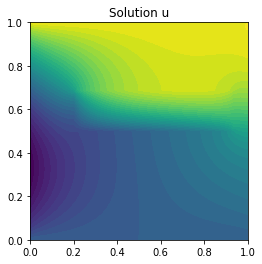

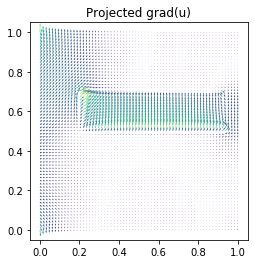

In [19]:
# Copyright (C) 2011 Marie E. Rognes
#
# This file is part of DOLFIN.
#
# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.
#
# First added:  2011-11-09
# Last changed: 2012-08-06

# Begin demo


from dolfin import *

# Create classes for defining parts of the boundaries and the interior
# of the domain
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 1.0)

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 1.0)

class Obstacle(SubDomain):
    def inside(self, x, on_boundary):
        return (between(x[1], (0.5, 0.7)) and between(x[0], (0.2, 0.95)))

# Initialize sub-domain instances
left = Left()
top = Top()
right = Right()
bottom = Bottom()
obstacle = Obstacle()

# Define mesh
mesh = UnitSquareMesh(64, 64)

# Initialize mesh function for interior domains
domains = MeshFunction("size_t", mesh, mesh.topology().dim())
domains.set_all(0)
obstacle.mark(domains, 1)

# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
top.mark(boundaries, 2)
right.mark(boundaries, 3)
bottom.mark(boundaries, 4)

# Define input data
a0 = Constant(1.0)
a1 = Constant(0.01)
g_L = Expression("- 10*exp(- pow(x[1] - 0.5, 2))", degree=2)
g_R = Constant(1.0)
f = Constant(1.0)

# Define function space and basis functions
V = FunctionSpace(mesh, "CG", 2)
u = TrialFunction(V)
v = TestFunction(V)

# Define Dirichlet boundary conditions at top and bottom boundaries
bcs = [DirichletBC(V, 5.0, boundaries, 2),
       DirichletBC(V, 0.0, boundaries, 4)]

# Define new measures associated with the interior domains and
# exterior boundaries
dx = Measure('dx', domain=mesh, subdomain_data=domains)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# Define variational form
F = (inner(a0*grad(u), grad(v))*dx(0) + inner(a1*grad(u), grad(v))*dx(1)
     - g_L*v*ds(1) - g_R*v*ds(3)
     - f*v*dx(0) - f*v*dx(1))

# Separate left and right hand sides of equation
a, L = lhs(F), rhs(F)

# Solve problem
u = Function(V)
solve(a == L, u, bcs)

# Evaluate integral of normal gradient over right boundary
n = FacetNormal(mesh)
m1 = dot(grad(u), n)*ds(3)
v1 = assemble(m1)
print("\int grad(u) * n ds(3) = ", v1)

# Evaluate integral of u over the obstacle
m2 = u*dx(1)
v2 = assemble(m2)
print("\int u dx(1) = ", v2)

# Plot solution
import matplotlib.pyplot as plt
plt.figure()
plot(u, title="Solution u")

# Plot solution and gradient
plt.figure()
plot(grad(u), title="Projected grad(u)")

# Show plots
plt.show()


\int grad(u) * n ds(3) =  -2.0628759889674786
\int u dx(1) =  0.2753699896202904


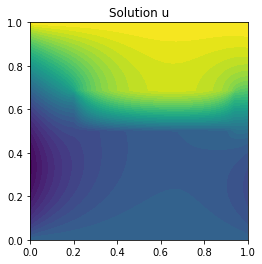

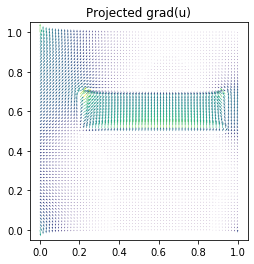

In [21]:
# Copyright (C) 2011 Marie E. Rognes
#
# This file is part of DOLFIN.
#
# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.
#
# First added:  2011-11-09
# Last changed: 2012-08-06

# Begin demo


from dolfin import *

# Create classes for defining parts of the boundaries and the interior
# of the domain
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 1.0)

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 1.0)

class Obstacle(SubDomain):
    def inside(self, x, on_boundary):
        return (between(x[1], (0.5, 0.7)) and between(x[0], (0.2, 0.95)))

# Initialize sub-domain instances
left = Left()
top = Top()
right = Right()
bottom = Bottom()
obstacle = Obstacle()

# Define mesh
mesh = UnitSquareMesh(64, 64)

# Initialize mesh function for interior domains
domains = MeshFunction("size_t", mesh, mesh.topology().dim())
domains.set_all(0)
obstacle.mark(domains, 1)

# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
top.mark(boundaries, 2)
right.mark(boundaries, 3)
bottom.mark(boundaries, 4)

# Define input data
a0 = Constant(1.0)
a1 = Constant(0.01)
g_L = Expression("- 10*exp(- pow(x[1] - 0.5, 2))", degree=2)
g_R = Constant(1.0)
f = Constant(1.0)
r_r = Constant(0.8) # robin r coefficient in r(u-s)
r_s = Constant(4.0) # robin s coefficient in r(u-s)

# Define function space and basis functions
V = FunctionSpace(mesh, "CG", 2)
u = TrialFunction(V)
v = TestFunction(V)

# Define Dirichlet boundary conditions at top and bottom boundaries
bcs = [DirichletBC(V, 5.0, boundaries, 2),
       DirichletBC(V, 0.0, boundaries, 4)]

# Define new measures associated with the interior domains and
# exterior boundaries
dx = Measure('dx', domain=mesh, subdomain_data=domains)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# Define variational form
F = (inner(a0*grad(u), grad(v))*dx(0) + inner(a1*grad(u), grad(v))*dx(1)
     - g_L*v*ds(1) - g_R*u*r_r*v*ds(3) + g_R*r_r*r_s*v*ds(3)
     - f*v*dx(0) - f*v*dx(1))

# Separate left and right hand sides of equation
a, L = lhs(F), rhs(F)

# Solve problem
u = Function(V)
solve(a == L, u, bcs)

# Evaluate integral of normal gradient over right boundary
n = FacetNormal(mesh)
m1 = dot(grad(u), n)*ds(3)
v1 = assemble(m1)
print("\int grad(u) * n ds(3) = ", v1)

# Evaluate integral of u over the obstacle
m2 = u*dx(1)
v2 = assemble(m2)
print("\int u dx(1) = ", v2)

# Plot solution
import matplotlib.pyplot as plt
plt.figure()
plot(u, title="Solution u")

# Plot solution and gradient
plt.figure()
plot(grad(u), title="Projected grad(u)")

# Show plots
plt.show()


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


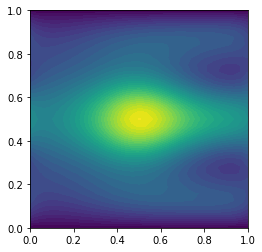

In [22]:
# This demo program solves Poisson's equation
#
#     - div grad u(x, y) = f(x, y)
#
# on the unit square with homogeneous Dirichlet boundary conditions
# at y = 0, 1 and periodic boundary conditions at x = 0, 1.
#
# Original implementation: ../cpp/main.cpp by Anders Logg
#
# Copyright (C) 2007 Kristian B. Oelgaard
#
# This file is part of DOLFIN.
#
# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.
#
# Modified by Anders Logg 2011
#
# First added:  2007-11-15
# Last changed: 2012-11-12
# Begin demo

import matplotlib.pyplot as plt
from dolfin import *

# Source term
class Source(UserExpression):
    def eval(self, values, x):
        dx = x[0] - 0.5
        dy = x[1] - 0.5
        values[0] = x[0]*sin(5.0*DOLFIN_PI*x[1]) \
                    + 1.0*exp(-(dx*dx + dy*dy)/0.02)

# Sub domain for Dirichlet boundary condition
class DirichletBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return bool((x[1] < DOLFIN_EPS or x[1] > (1.0 - DOLFIN_EPS)) \
                    and on_boundary)

# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[0] < DOLFIN_EPS and x[0] > -DOLFIN_EPS and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - 1.0
        y[1] = x[1]

# Create mesh and finite element
mesh = UnitSquareMesh(32, 32)
V = FunctionSpace(mesh, "CG", 1, constrained_domain=PeriodicBoundary())

# Create Dirichlet boundary condition
u0 = Constant(0.0)
dbc = DirichletBoundary()
bc0 = DirichletBC(V, u0, dbc)

# Collect boundary conditions
bcs = [bc0]

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Source(degree=1)
a = dot(grad(u), grad(v))*dx
L = f*v*dx

# Compute solution
u = Function(V)
solve(a == L, u, bcs)

# Save solution to file
file = File("periodic.pvd")
file << u

# Plot solution
plot(u)
plt.show()
